# Deep Learning

_May your choices reflect your hopes, not your fears_ – Nelson Mandela

Concepts: 
- TextBlob library
- Word Embeddings
- Feedforward Neural Networks

References:

- Geoffrey E. Hinton, Nitish Srivastava, Alex Krizhevsky, Ilya Sutskever, 
Ruslan R. Salakhutdinov, July 2012, "Improving neural networks by preventing 
co-adaptation of feature detectors"

- Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation.

- Tomas Mikolov, Kai Chen, Greg Corrado, Jeffrey Dean, 2013, "Efficient Estimation of Word Representations in Vector Space"

- Greg Durrett, 2023, "CS388 Natural Language Processing course materisl", retrieved from https://www.cs.utexas.edu/~gdurrett/courses/online-course/materials.html

In [1]:
import numpy as np
import random
import time
import pandas as pd
from pandas import DataFrame, Series
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm
import torch
from torch import nn
import torchinfo
from textblob import TextBlob
from tqdm import tqdm
from finds.database import MongoDB, SQL, RedisDB
from finds.unstructured import Unstructured, Edgar, Vocab
from finds.structured import BusDay, CRSP, PSTAT
from finds.readers import Sectoring
from finds.utils import Store
from secret import credentials, paths
# %matplotlib qt
# jupyter-notebook --NotebookApp.iopub_data_rate_limit=1.0e12
VERBOSE = 0
outdir = paths['scratch']
store = Store(outdir, ext='pkl')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device is', device)

device is cuda


In [2]:
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
bd = BusDay(sql)
rdb = RedisDB(**credentials['redis'])
crsp = CRSP(sql, bd, rdb, verbose=VERBOSE)
pstat = PSTAT(sql, bd, verbose=VERBOSE)
ed = Edgar(paths['10X'], zipped=True, verbose=VERBOSE)

Last FamaFrench Date 2024-04-30 00:00:00


Load business descriptions text and industry labels for universe of stocks


In [3]:
# Retrieve universe of stocks as of start of calendar year 2023
univ = crsp.get_universe(bd.endmo(20221231))

In [4]:
# lookup company names
comnam = crsp.build_lookup(source='permno', target='comnam', fillna="")
univ['comnam'] = comnam(univ.index)

In [5]:
# lookup ticker symbols
ticker = crsp.build_lookup(source='permno', target='ticker', fillna="")
univ['ticker'] = ticker(univ.index)

In [6]:
# lookup sic codes from Compustat, and map to FF 10-sector code
sic = pstat.build_lookup(source='lpermno', target='sic', fillna=0)
industry = Series(sic[univ.index], index=univ.index)
industry = industry.where(industry > 0, univ['siccd'])
sectors = Sectoring(sql, scheme='codes10', fillna='')   # supplement from crosswalk
univ['sector'] = sectors[industry]

In [7]:
# retrieve 2023 10K business descriptions text
item, form = 'bus10K', '10-K'
rows = DataFrame(ed.open(form=form, item=item))
found = rows[rows['date'].between(20230101, 20231231)]\
             .drop_duplicates(subset=['permno'], keep='last')\
             .set_index('permno')

## Textblob


The TextBlob library provides simple API for common NLP tasks such as
part-of-speech tagging, lemmatization, noun phrase extraction, sentiment analysis
and spelling correction.
It streamlines many of NLTK's complexities and also integrates WordNet.
- https://textblob.readthedocs.io/en/dev/quickstart.html

In [9]:
bus = {}
for permno in tqdm(found.index):
    if permno not in univ.index:
        continue
    doc = TextBlob(ed[found.loc[permno, 'pathname']].lower())  # tokenize and tag
    nouns = [word for word, tag in doc.tags
             if tag in ['NN', 'NNS'] and word.isalpha() and len(word) > 2]
    if len(nouns) > 100:
        bus[permno] = nouns
permnos = list(bus.keys())

100%|██████████| 4625/4625 [18:12<00:00,  4.24it/s]


## Word Embeddings

Word embeddings or vectors may be trained using neural networks or matrix factorization techniques.

### Word2Vec

Word2Vec is a framework that includes two primary algorithms: Skip-gram and CBOW. It aims to learn distributed representations (word embeddings) of words in a continuous vector space, by ccapturing  relationships between words based on their occurrences as center words in context windows. Training uses neural networks, that are typically shallow with one hidden layer.

### Skip-gram

This approach predicts the context words (i.e. surrounding words) given a center word.

### CBOW

Continuous Bag of Words (CBOW) predicts the center word based on the context words within a fixed window size.

### GloVe

Global Vectors for Word Representation (GloVe) learns word vectors from global word-word co-occurrence statistics from a corpus.
It uses matrix factorization techniques on the word co-occurrence matrix.



Load GloVe vectors, and relativize to vocab words


In [10]:
# Load GloVe embeddings, source: "https://nlp.stanford.edu/data/glove.6B.zip"
embeddings_dim = 300  # dimension of GloVe embeddings vector

filename = paths['scratch'] / f"glove.6B.{embeddings_dim}d.txt"
embeddings = pd.read_csv(filename, sep=" ", quoting=3,
                         header=None, index_col=0, low_memory=True)
embeddings.index = embeddings.index.astype(str).str.lower()
print(embeddings.shape)


(400000, 300)


### Word Vector Arithmetic

Reflecting the idea that geometric relationships between word embeddings reflect meaningful inguistic relationships, word embeddings may be combined and manipulated arithmetically to capture analogies and semantic similarities between words.

It should noted that these examples are only suggestive of what the vectors may capture, and such mathematical results are generally not as sharp; they may also show the potential for biases, such as gender roles, implicit in the training samples.


In [11]:
from sklearn.neighbors import NearestNeighbors
analogies = ["man king woman", "paris france tokyo", "big bigger cold"]
for analogy in analogies:
    words = analogy.lower().split()
    vectors = {word: embeddings.loc[word].values for word in words}
    vec = vectors[words[1]] - vectors[words[0]] + vectors[words[2]]

    sim = NearestNeighbors(n_neighbors=1).fit(embeddings)
    neighbors = sim.kneighbors(vec.reshape((1, -1)), n_neighbors=2,
                               return_distance=False).flatten().tolist()
    neighbors = [k for k in neighbors if embeddings.index[k] not in words]
    print(f"{words[1]} - {words[0]} + {words[2]} =",
          [embeddings.index[k] for k in neighbors])

king - man + woman = ['queen']
france - paris + tokyo = ['japan']
bigger - big + cold = ['colder']


Encode textual dataset and labels, and relativize word embeddings to vocab


In [12]:
words = Counter()
for nouns in bus.values():
    words.update(list(nouns))
vocab = Vocab(words.keys())
print('vocab len:', len(vocab))

vocab len: 87381


In [13]:
labels = []
x_all = []
for permno, nouns in bus.items():
    x = vocab.get_index([noun for noun in nouns])
    if sum(x):
        labels.append(univ.loc[permno, 'sector'])
        x_all.append(x)
class_encoder = LabelEncoder().fit(labels)    # .inverse_transform()
y_all = class_encoder.transform(labels)

In [14]:
store['dan'] = dict(y_all=y_all, x_all=x_all)

In [ ]:
# retrieve from previously stored
y_all, x_all = store['dan'].values()

In [15]:
# relativize embeddings to words in vocab
vocab.set_embeddings(embeddings)
print(vocab.embeddings.shape)

(87381, 300)


In [16]:
vocab.dump(outdir / f"dan{embeddings_dim}.pkl")

In [ ]:
# load vocab
vocab.load(outdir / f"dan{embeddings_dim}.pkl")

## FeedForward Neural Network

Neural networks compose together linear and nonlinear functions to build a complex mathematical model. Feedforward neural networks (FFNNs) are the simplest form of neural networks, where the data flows in one direction (a forward pass) and the connections do not form a cycle.

- __Neurons__ are the basic computational units or nodes of a neural network.
  Each neuron receives input, processes it using a weighted sum and a bias term, and then applies an activation function to produce an output, which is then passed to the neurons in the next layer.

- __Activation functions__ are the nonlinear mathematical functions applied to neurons in a neural network. They introduce non-linearity into the model, enabling it to learn and represent complex patterns in the data. Common activation functions include ReLU (Rectified Linear Unit), sigmoid, and tanh.

- __Input Layer__ is the first layer of a neural network which directly receives the input data. Each neuron in the input layer represents one feature of the input.
  
- __Hidden Layers__, between the input layer and the output layer, take input from the previous layer of neurons, apply weights, biases, and activation functions, and pass the output to the next layer.

- __Output Layer__ is the final layer of the neural network and it produces the network’s output. Its neurons represent the predictions or classifications made by the network. The number of neurons in the output layer corresponds to the number of output classes or the dimensionality of the output. For classification tasks, softmax or sigmoid functions are often used in the output layer to provide probability distributions of the class predictions.

- __Backpropagation__ is used for training neural networks by updating the weights of neurons based on the error (loss) of the network's predictions: it involves calculating the gradient of the loss function with respect to each weight by using the chain rule of calculus, and propagating these gradients backward from the output layer to the input layer.

- __Computation Graph__ is a graphical representation of the sequence of operations used to compute the forward pass and the backward pass for backpropagation. PyTorch's modules automatically constructs the computation graph and computes gradients, hence simplifying the implementation of neural networks.

- __Batching__ divides the training data into smaller subsets called batches, rather than
training the model on the entire dataset at once, which can be computationally intensive and inefficient. It also gives speedup compared to training the network one sample at a time due to more eﬃcient matrix operations.

- __Initialization__ refers to the process of setting the initial values of the weights in a neural network before training begins. Poor initialization can lead to slow convergence or getting stuck in local minima. Common initialization methods include Xavier (Glorot) and He initialization
 
- __Dropout__ is a regularization technique during training, where a random subset of neurons is "dropped out" or set to zero at each iteration. This reduces overfitting by ensuring that the model does not rely too heavily on any particular subset of neurons. Geoffrey Hinton, et al. in their 2012 paper that first introduced dropout. They found that using a simple method of 50% dropout for all hidden units and  20% dropout for input units achieve improved results with a range of  neural networks on different problem types. It is not used on the output layer.

- __Adam__ (Adaptive Moment Estimation) is an optimization algorithm for training neural networks which improves on stochastic gradient descent and achieves good performance on problems with large, high-dimensional data sets. It adapts the learning rate for each parameter by computing adaptive learning rates from estimates of first and second moments of the gradients.


### Deep Averaging Networks

Deep Averaging Networks (DAN) are feedforward neural networks for natural language processing tasks which work by simply averaging the pre-trained embeddings of the words in a text sample to pass to its input layer. 

During training, the embeddings may be frozen (i.e. kept constant) or fine-tuned (i.e. allowed to be updated). 

- Freezing embeddings is useful when the embeddings are already well-trained and expected to generalize well to new tasks. It reduces the number of parameters to be trained, which can make the training process faster and prevent overfitting when the dataset is small.
   
- Fine-tuning embeddings means allowing the pre-trained word embeddings to be updated during the training of a model. Adjusting the embeddings can better fit the specific task or dataset at hand, bit requires more computational resources and a larger dataset to avoid overfitting.



In [17]:
class DAN(nn.Module):
    """Deep Averaging Network for classification"""
    def __init__(self,
                 vocab_dim,
                 num_classes,
                 hidden,
                 embedding,
                 freeze=True):
        super().__init__()
        self.embedding = nn.EmbeddingBag.from_pretrained(embedding)
        self.embedding.weight.requires_grad = not freeze
        D = nn.Dropout(0.0)
        V = nn.Linear(vocab_dim, hidden[0])
        nn.init.xavier_uniform_(V.weight)
        L = [D, V]
        self.drops = [D]
        for in_dim, out_dim in zip(hidden, hidden[1:] + [num_classes]):
            L.append(nn.ReLU())   # nonlinearity layer
            D = nn.Dropout(0.0)
            self.drops.append(D)
            L.append(D)           # dropout layer
            W = nn.Linear(in_dim, out_dim)   # dense linear layer
            nn.init.xavier_uniform_(W.weight)
            L.append(W)
        self.network = nn.Sequential(*L)
        self.classifier = nn.LogSoftmax(dim=-1)  # output is (N, C) logits

    def set_dropout(self, dropout):
        if dropout:
            self.drops[0] = 0.2    # input layer
            for i in range(1, len(self.drops)):    # hidden layers
                self.drops[i].p = 0.5
        else:
            for i in range(len(self.drops)):
                self.drops[i].p = 0.0

    def set_freeze(self, freeze):
        """To freeze part of the model (embedding layer)"""
        self.embedding.weight.requires_grad = not freeze

    def forward(self, x):
        """Return tensor of log probabilities"""
        return self.classifier(self.network(self.embedding(x)))

    def predict(self, x):
        """Return predicted int class of input tensor vector"""
        return torch.argmax(self(x), dim=1).int().tolist()

    def save(self, filename):
        """save model state to filename"""
        return torch.save(self.state_dict(), filename)

    def load(self, filename):
        """load model name from filename"""
        self.load_state_dict(torch.load(filename, map_location='cpu'))
        return self    

Split the data into stratified (i.e. equal class proportions) train and test set


In [30]:
# Stratified train_test split
num_classes = len(np.unique(labels))
train_index, test_index = train_test_split(
    np.arange(len(y_all)), stratify=y_all, random_state=42, test_size=0.2)
print(len(x_all), len(y_all), len(train_index), len(test_index), num_classes)
#Series(labels).value_counts().rename('count').to_frame()
pd.concat([Series(np.array(labels)[train_index]).value_counts().rename('Train'),
           Series(np.array(labels)[test_index]).value_counts().rename('Test')],
           axis=1)


3559 3559 2847 712 10


,Train,Test
Hlth,705,176
Other,609,153
HiTec,565,141
Manuf,275,69
Shops,257,64
Durbl,131,33
NoDur,116,29
Enrgy,75,19
Utils,74,18
Telcm,40,10


In [19]:
# Specify model and training parameters
layers = 1
hidden_size = 32
model = DAN(embeddings_dim,
            num_classes,
            hidden=[hidden_size] * layers,
            embedding=torch.FloatTensor(vocab.embeddings)).to(device)
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
DAN                                      --
├─EmbeddingBag: 1-1                      (26,214,300)
├─Sequential: 1-2                        --
│    └─Dropout: 2-1                      --
│    └─Linear: 2-2                       9,632
│    └─ReLU: 2-3                         --
│    └─Dropout: 2-4                      --
│    └─Linear: 2-5                       330
├─LogSoftmax: 1-3                        --
Total params: 26,224,262
Trainable params: 9,962
Non-trainable params: 26,214,300

In [20]:
batch_sz = 16
lr = 0.001 
num_epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_function = nn.NLLLoss()

/home/terence/env3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Helper function to batch and form an input for neural network.  Pads each sample to have lengths equal to the max, and convert to Long tensor type.

In [21]:
def form_input(docs):
    """Pad lists of index lists to form batch of equal lengths"""
    lengths = [len(doc) for doc in docs]   # length of each doc                     
    max_length = max(1, max(lengths))      # to pad so all lengths equal max        
    out = [doc + ([0] * (max_length-n)) for doc, n in zip(docs, lengths)]
    return torch.LongTensor(out)

In [22]:
accuracy = []
for imodel, (freeze, dropout) in enumerate([(True, False), (False, False), (False, True)]):
    model.set_freeze(freeze=freeze)
    model.set_dropout(dropout=dropout)
    accuracy.append(dict())

    # Loop over epochs
    for epoch in tqdm(range(num_epochs)):
        tic = time.time()

        # Form batches
        random.shuffle(train_index)
        batches = [train_index[i:(i+batch_sz)]
                   for i in range(0, len(train_index), batch_sz)]

        # Train in batches
        total_loss = 0.0
        model.train()
        for batch in batches:  # train by batch
            x = form_input([x_all[idx] for idx in batch]).to(device)
            y = torch.LongTensor([y_all[idx] for idx in batch]).to(device)
            model.zero_grad()                    # reset model gradient
            log_probs = model(x)                 # run model
            loss = loss_function(log_probs, y)   # compute loss
            total_loss += float(loss)
            loss.backward()                      # loss step
            optimizer.step()                     # optimizer step
        model.eval()
        model.save(outdir / f"dan{embeddings_dim}.pt")

        if VERBOSE:
            print(f"Loss {epoch}/{num_epochs} {(freeze, dropout)}:" +
                  f"{total_loss:.1f}")

        with torch.no_grad():   # evaluate test error
            test_pred = [model.predict(form_input([x_all[i]]).to(device))[0]
                         for i in test_index]
            test_gold = [y_all[idx] for idx in test_index]
            test_correct = (np.array(test_pred) == np.array(test_gold)).sum() 
            train_pred = [model.predict(form_input([x_all[i]]).to(device))[0]
                          for i in train_index]
            train_gold = [y_all[idx] for idx in train_index]
            train_correct = (np.array(train_pred) == np.array(train_gold)).sum() 
            accuracy[imodel][epoch] = {
                'loss': total_loss,
                'train': train_correct/len(train_gold),
                'test': test_correct/len(test_gold)}

            if VERBOSE:
                print(freeze,
                      dropout,
                      epoch,
                      int(time.time() - tic),
                      optimizer.param_groups[0]['lr'],
                      train_correct/len(train_gold),
                      test_correct/len(test_gold))

100%|██████████| 50/50 [03:55<00:00,  4.72s/it]


Display the confusion matrix for train and test sets


In [23]:
classes = class_encoder.classes_
cf_train = DataFrame(confusion_matrix(train_gold, train_pred),
                     index=pd.MultiIndex.from_product([['Actual'], classes]),
                     columns=pd.MultiIndex.from_product([['Predicted'], classes]))
cf_test = DataFrame(confusion_matrix(test_gold, test_pred),
                    index=pd.MultiIndex.from_product([['Actual'], classes]),
                    columns=pd.MultiIndex.from_product([['Predicted'], classes]))

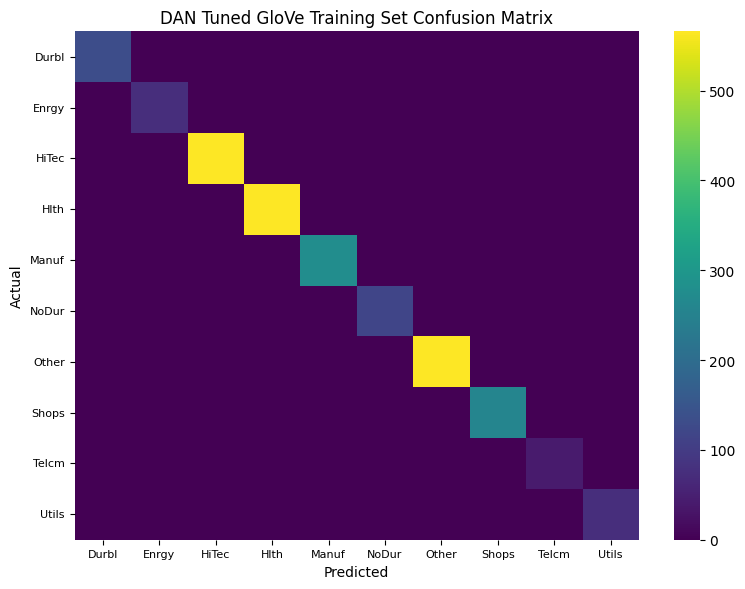

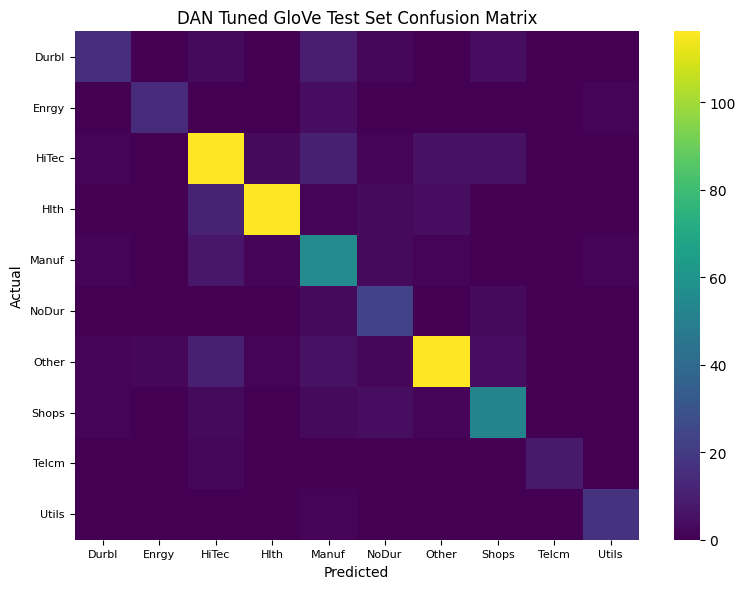

In [24]:
for num, (title, cf) in enumerate({'Training': cf_train,
                                   'Test': cf_test}.items()):
    fig, ax = plt.subplots(num=1+num, clear=True, figsize=(8, 6))
    sns.heatmap(cf, ax=ax, annot= False, fmt='d', cmap='viridis', robust=True,
                yticklabels=class_encoder.classes_,
                xticklabels=class_encoder.classes_)
    ax.set_title(f'DAN Tuned GloVe {title} Set Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.yaxis.set_tick_params(labelsize=8, rotation=0)
    ax.xaxis.set_tick_params(labelsize=8, rotation=0)
    plt.subplots_adjust(left=0.35, bottom=0.25)
    plt.tight_layout()

Plot accuracy, on train and test sets, by epoch. Training begins with frozen embeddings, then embeddings are unfrozen to allow fine-tuning, and finally dropout is implemented.


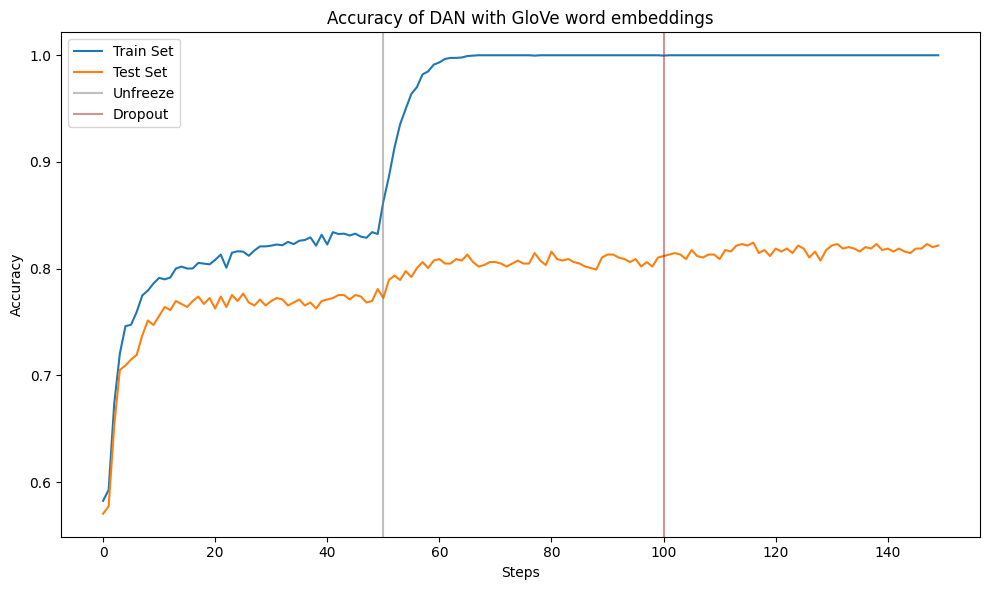

In [25]:
train_accuracy = pd.concat([Series([epoch['train'] for epoch in acc.values()])
                            for acc in accuracy],
                           ignore_index=True)
test_accuracy = pd.concat([Series([epoch['test'] for epoch in acc.values()])
                           for acc in accuracy],
                          ignore_index=True)

fig, ax = plt.subplots(num=1, clear=True, figsize=(10, 6))
train_accuracy.plot(ax=ax)
test_accuracy.plot(ax=ax)
ax.axvline(len(accuracy[0]), c='grey', alpha=0.5)
ax.axvline(len(accuracy[0]) + len(accuracy[1]), c='brown', alpha=0.5)
ax.set_title(f'Accuracy of DAN with GloVe word embeddings')
ax.set_xlabel('Steps')
ax.set_ylabel('Accuracy')
ax.legend(['Train Set', 'Test Set','Unfreeze','Dropout'], loc='upper left')
plt.tight_layout()

When embeddings are frozen, the model overfits the training data, achieving 100% training accuracy.  When dropout regularization is enabled, the test set accuracy slightly improves.

In [26]:
# Accuracy when frozen embeddings, unfrozen and with dropouts
p = (len(accuracy[0]) - 1, len(accuracy[0]) + len(accuracy[1]) - 1, -1)
print("Accuracy")
DataFrame({'frozen': [train_accuracy.iloc[p[0]], test_accuracy.iloc[p[0]]], 
           'unfrozen': [train_accuracy.iloc[p[1]], test_accuracy.iloc[p[1]]], 
           'dropout': [train_accuracy.iloc[p[2]], test_accuracy.iloc[p[2]]]},
          index=['train', 'test'])

Accuracy


,frozen,unfrozen,dropout
train,0.832455,1.000000,1.000000
test,0.780899,0.810393,0.821629
